In [1]:
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
from IPython.display import clear_output
from matplotlib.image import imsave

In [15]:
img1 = cv2.imread("./project2/images/t3_1.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread("./project2/images/t3_2.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img3 = cv2.imread("./project2/images/t3_3.png")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

img4 = cv2.imread("./project2/images/t3_4.png")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

imgs = [img1,img2,img3,img4]

<Figure size 432x288 with 0 Axes>

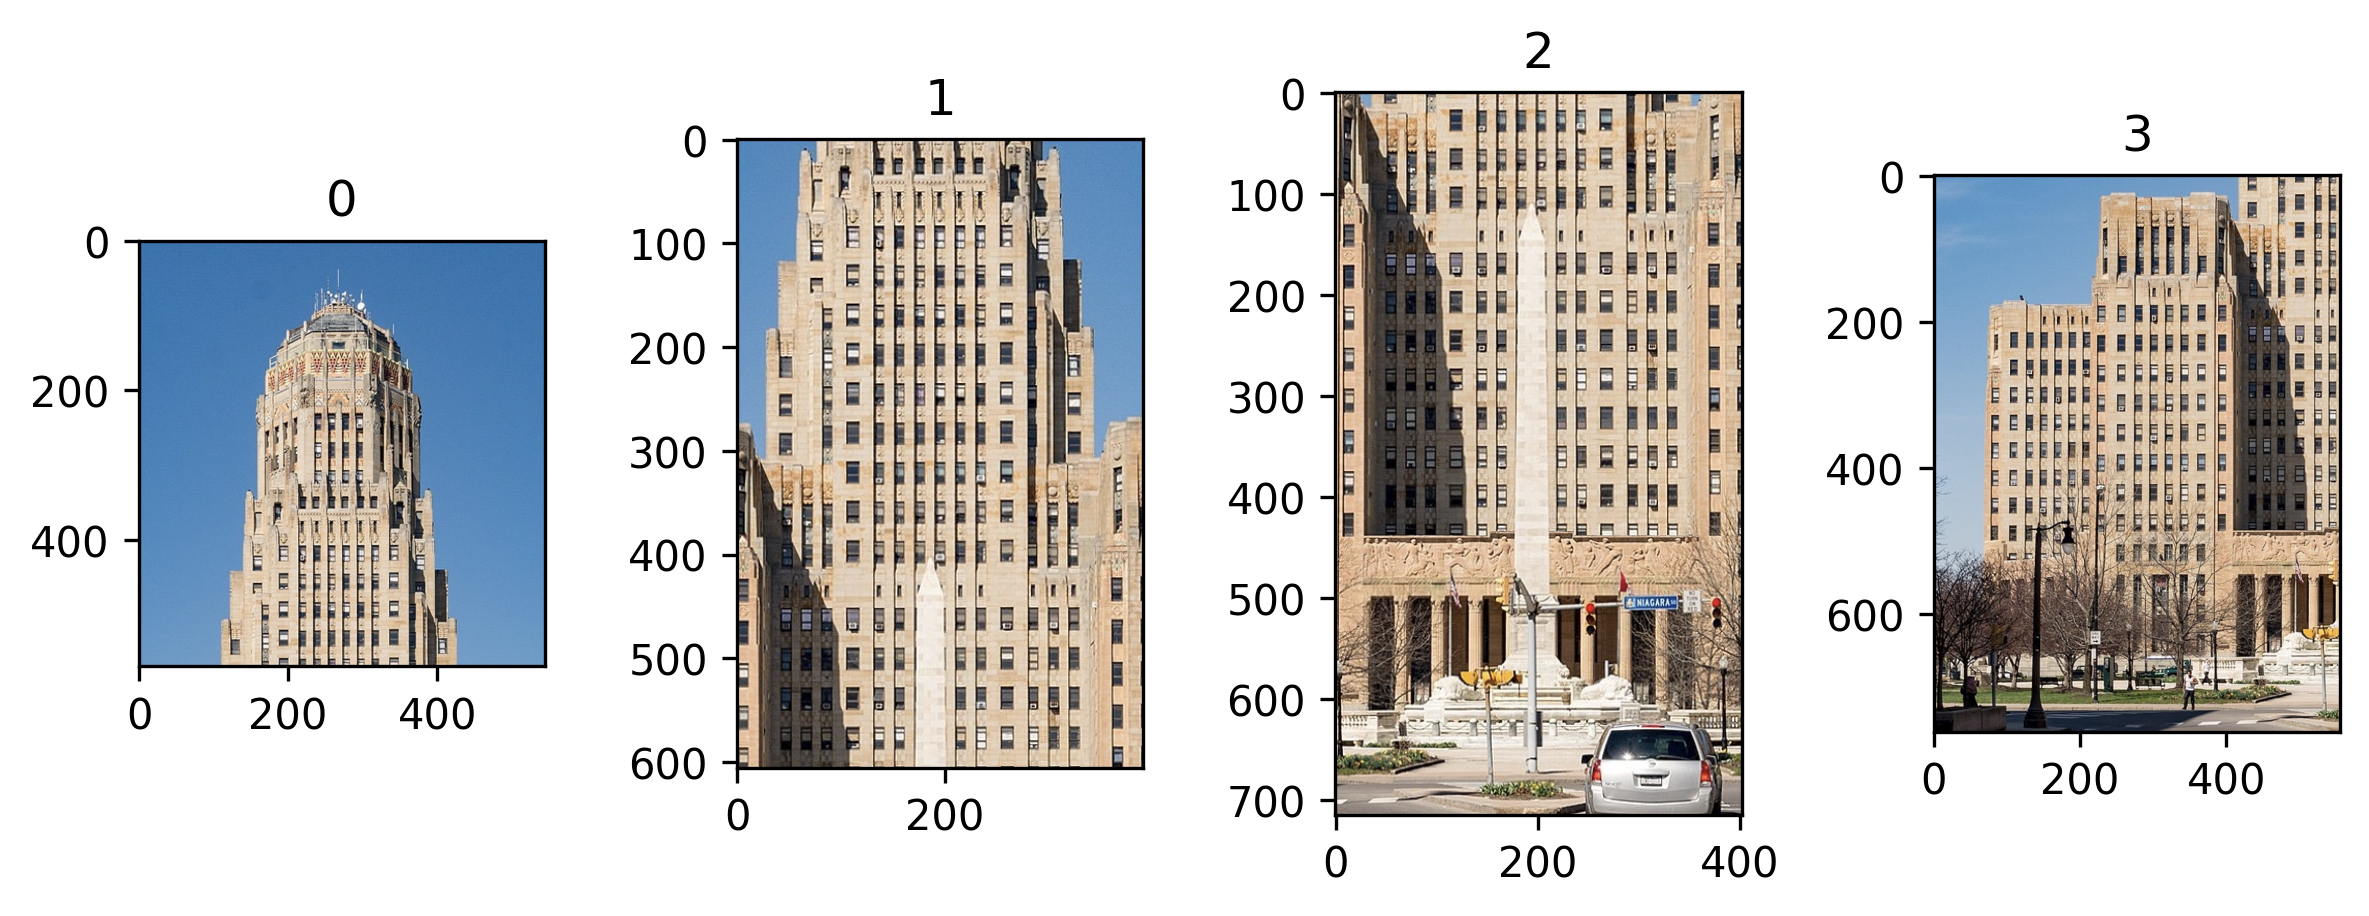

In [16]:
plt.figure()
f, axarr = plt.subplots(1,4,figsize=(8,8),dpi=300) 
axarr[0].imshow(img1)
axarr[0].title.set_text(0)
axarr[1].imshow(img2)
axarr[1].title.set_text(1)
axarr[2].imshow(img3)
axarr[2].title.set_text(2)
axarr[3].imshow(img4)
axarr[3].title.set_text(3)
f.tight_layout()

In [48]:
def get_features(imgs):
    orb = cv2.ORB_create(nfeatures=2000,scoreType=cv2.ORB_FAST_SCORE)
    feature_list = []
    for img in imgs:
        kp = orb.detect(img,None)
        kp, des = orb.compute(img, kp)
        feature_list.append((kp,des))
        # plt.figure()
        # plt.imshow(cv2.drawKeypoints(img, kp, None))
    return feature_list


def hamming_distance(x, y):
    dis_array = x ^ y
    dis_sum = np.unpackbits(dis_array).sum()
    return float(dis_sum)

def match(des1,des2,threshold=0.7):
    matches = []
    count = 0
    length = len(des1)
    length2 = len(des2)
    for i in range(length):
        first = (float('inf'),None,None)
        second = (float('inf'),None,None)
        for j in range(length2):
            distance = hamming_distance(des1[i],des2[j])
            if distance < first[0]:
                second = first
                first = (distance,i,j)
            elif distance < second[0]:
                second = (distance,i,j)
        if first[0] < threshold * second[0]:
            matches.append(cv2.DMatch(first[1],first[2],distance))
            count += 1
            
        print(f'[{i+1}/{length}] {count} matches found',end="\r")

    return matches,count

def cross_match(features):
    le = len(features)
    cross = np.zeros((le,le))
    matches_record = []
    for i in range(le):
        for j in range(le):
            if i != j:
                print(f'matching [{i},{j}]')
                kp1,des1 = features[i]
                kp2,des2 = features[j]
                matches,count = match(des1,des2)
                matches_record.append(matches)
                cross[i,j] = count
                print(f'found {count} matches between {i} and {j}')
            else:
                matches_record.append([])
    return matches_record,cross

def homo(x):
    out = (x[0],x[1],1)
    return out

def cart(x):
    out = []
    for point in x:
        if point[2] != 0:
            out.append([point[0]/point[2],point[1]/point[2]])
        else:
            out.append([0.,0.])
    return np.array(out)

def warp(img1, img2, M,Mp):
    img1_dims = np.float32([[0,0],[0,img1.shape[0]],[img1.shape[1],img1.shape[0]],[img1.shape[1],0]]).reshape(-1,1,2)
    img2_dims = np.float32([[0,0],[0,img2.shape[0]],[img2.shape[1],img2.shape[0]],[img2.shape[1],0]]).reshape(-1,1,2)
    print(Mp,M)
    img2_trans_dims = cv2.perspectiveTransform(img2_dims, Mp @ M)
    final_img_dims = np.concatenate((img1_dims, img2_trans_dims), axis=0)
    [xmin, ymin] = np.int32(final_img_dims.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(final_img_dims.max(axis=0).ravel() + 0.5)
    Mx = np.array([[1,0,-xmin],[0,1,-ymin],[0,0,1]]) 
    img2_out = cv2.warpPerspective(img2,  Mx @ Mp @M, (xmax-xmin, ymax-ymin))
    img1_out = np.pad(img1,((-ymin,img2_out.shape[0]-(img1.shape[0]-ymin)),(-xmin,img2_out.shape[1]-(img1.shape[1]-xmin)),(0,0)))
    return img1_out,img2_out, Mx @ Mp, M

def ransac(kp1,kp2,matches):
    req_prob = 0.99999
    total = len(matches)
    max_iters = 1000
    sam_pts = max(4,int(len(matches)/10))
    
    src_pts = np.float32([ homo(kp1[m.queryIdx].pt) for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    
    max_dims = dst_pts.max(axis=0)
    
    inlier_distance = max_dims[0] * max_dims[1] /1000
    best_case = (0,None,np.zeros(total))
    i = 0
    iters = max_iters
    while iters > i:
        sample  = random.sample(matches,sam_pts)
        sample_src_pts = np.float32([ kp1[m.queryIdx].pt for m in sample ])
        sample_dst_pts = np.float32([ kp2[m.trainIdx].pt for m in sample ])
        M ,mask = cv2.findHomography(sample_src_pts,sample_dst_pts)
        trans_pts = cart(np.dot(M,src_pts.transpose()).transpose())
        inliers = np.sum((trans_pts - dst_pts)**2,axis=1) < inlier_distance
        inlier_count = sum(inliers)
        if inlier_count > best_case[0]:
            best_case = (inlier_count,M,inliers)
            cal_inliers = max(3,inlier_count)
            iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))
        i += 1
        
    print(f'{best_case[0]} inliers and {len(matches)-best_case[0]} outliers found {i}')
    
    inlier_src_pts = []
    inlier_dst_pts = []
    for i in range(len(matches)):
        if best_case[2][i]:
            inlier_src_pts.append(kp1[matches[i].queryIdx].pt)
            inlier_dst_pts.append(kp2[matches[i].trainIdx].pt)
    inlier_src_pts = np.float32(inlier_src_pts)
    inlier_dst_pts = np.float32(inlier_dst_pts)
    M ,mask = cv2.findHomography(inlier_src_pts,inlier_dst_pts)
    return M

def mask2(img1,img2):
    gray1 = 0.2989 * img1[:,:,0] + 0.5870 * img1[:,:,1] + 0.1140 * img1[:,:,2]
    gray2 = 0.2989 * img2[:,:,0] + 0.5870 * img2[:,:,1] + 0.1140 * img2[:,:,2]
    mask2 = np.logical_and(np.logical_xor(gray1,gray2),np.logical_not(gray1)) * 1
    return mask2.astype(int),np.logical_and(gray1,gray2).astype(int)

def deghost1(img0,img1,mask_xor,mask_and,size=5):
    h,w = img0.shape[:2]
    refh = np.zeros(img0.shape)
    refw = np.zeros(img0.shape)
    mask_andt = np.tile(mask_and[...,None],3)
    refw[:,0,:] = img0[:,0,:] * mask_andt[:,0,:]
    trackerw = [0]
    
    last = 0
    for i in range(1,w):
        val0 = ((img0[:,i,:] - refw[:,i-1,:]) * mask_andt[:,i,:]).sum()
        val1 = ((img1[:,i,:] - refw[:,i-1,:]) * mask_andt[:,i,:]).sum()
        if val0 > val1:
            refw[:,i,:] = img0[:,i,:] * mask_andt[:,i,:]
            if last == 1:
                trackerw.append(i)
                last = 0
        else:
            refw[:,i,:] = img1[:,i,:] * mask_andt[:,i,:]
            if last == 0:
                trackerw.append(i)
                last = 1
    if trackerw[-1] != w:
        trackerw.append(w)
    
    refh = []
    trackerh = []
    for i in range(1,len(trackerw)):
        x = np.zeros((h,trackerw[i]-trackerw[i-1],3))
        x[0,:,:] = img0[0,trackerw[i-1]:trackerw[i],:]
        refh.append(x)
        trackerh.append(np.zeros((h,trackerw[i]-trackerw[i-1])))
    
    for i,(col,trackh_col) in enumerate(zip(refh,trackerh)):
        for j in range(1,h):         
            val0 = ((img0[j,trackerw[i]:trackerw[i+1],:] - col[j-1,:,:]) * mask_andt[j,trackerw[i]:trackerw[i+1],:]).sum()
            val1 = ((img1[j,trackerw[i]:trackerw[i+1],:] - col[j-1,:,:]) * mask_andt[j,trackerw[i]:trackerw[i+1],:]).sum()
            
            if val0 > val1:
                col[j,:,:] = img0[j,trackerw[i]:trackerw[i+1],:] * mask_andt[j,trackerw[i]:trackerw[i+1],:]
                trackh_col[j,:] = 0 #* mask_and[j,trackerw[i]:trackerw[i+1]]
                
            else:
                col[j,:,:] = img1[j,trackerw[i]:trackerw[i+1],:] * mask_andt[j,trackerw[i]:trackerw[i+1],:]
                trackh_col[j,:] = 1 #* mask_and[j,trackerw[i]:trackerw[i+1]]
        refh[i] = col.astype('uint8')
        trackerh[i] = trackh_col.astype('uint8')
        
    img1_mask = (np.hstack(trackerh) * mask_and) + mask_xor
    img0_mask = np.logical_not(img1_mask)
            
    img1_mask = np.tile(img1_mask[...,None],3)
    img0_mask = np.tile(img0_mask[...,None],3)
    return (img0_mask * img0 +img1_mask * img1).astype('uint8')

def construct_graph(cross,le):
    graph = {k: [] for k in range(le)}
    for i in range(le):
        graph[cross[i].argmax()].append(i)
    return graph

def get_root(graph):
    return max(graph, key= lambda x: len(set(graph[x])))

def dfs(visited, graph, node,out): 
    if node not in visited:
        out.append(node)
        visited.add(node)
        _ = dfs(visited, graph, graph[node],out)
    return out

In [18]:
features = get_features(imgs)
matchs,cross = cross_match(features)

matching [0,1]
found 455 matches between 0 and 1
matching [0,2]
found 42 matches between 0 and 2
matching [0,3]
found 22 matches between 0 and 3
matching [1,0]
found 532 matches between 1 and 0
matching [1,2]
found 596 matches between 1 and 2
matching [1,3]
found 169 matches between 1 and 3
matching [2,0]
found 42 matches between 2 and 0
matching [2,1]
found 558 matches between 2 and 1
matching [2,3]
found 190 matches between 2 and 3
matching [3,0]
found 27 matches between 3 and 0
matching [3,1]
found 128 matches between 3 and 1
matching [3,2]
found 182 matches between 3 and 2


In [21]:
graph = construct_graph(cross,4)

In [22]:
graph

{0: [], 1: [0, 2], 2: [1, 3], 3: []}

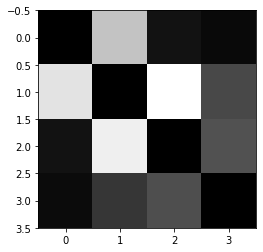

In [23]:
plt.imshow(cross,cmap='gray')

In [38]:
M = ransac(features[1][0],features[0][0],matchs[1*4 + 0])
a,b,M1,M2 = warp(imgs[0],imgs[1],M,np.eye(3))
x,y = mask2(a,b)
res = deghost1(a,b,x,y,9)

C:\Users\naine\AppData\Local\Temp\ipykernel_9316\3638040449.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))


385 inliers and 147 outliers found 1000


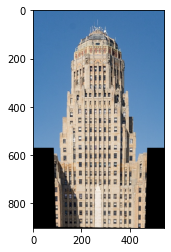

In [39]:
plt.imshow(res)

In [40]:
M = ransac(features[2][0],features[1][0],matchs[2*4 + 1])
a,b,M1,M2 = warp(res,imgs[2],M,M1)
x,y = mask2(a,b)
res = deghost1(a,b,x,y,9)

C:\Users\naine\AppData\Local\Temp\ipykernel_9316\3638040449.py:110: RuntimeWarning: divide by zero encountered in double_scalars
  iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))


509 inliers and 49 outliers found 1000


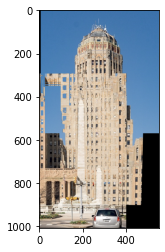

In [41]:
plt.imshow(res)

In [575]:
M = ransac(features[2][0],features[1][0],matchs[2*4 + 1])
a,b,M1,M2 = warp(res,imgs[2],M,M1@M2)
x,y = mask2(a,b)
res = deghost1(a,b,x,y,9)

133 inliers and 49 outliers found 6507


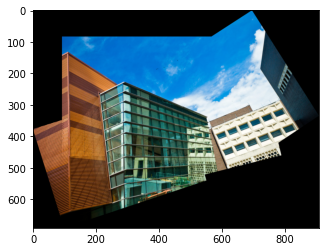

In [576]:
plt.imshow(res)

In [53]:
max(graph, key= lambda x: len(set(graph[x])))

1

In [46]:
visited

{3}

In [50]:
visited = set()
matrix_tracker = [None for i in range(4)]
matrix_tracker[1] = np.eye(3)
def dfs(visited, graph,node,res):
    if node not in visited:
        visited.add(node)
        for neighbour in graph[node]:
            if neighbour not in visited:
                print(f'stitching image {node} and {neighbour}')
                
                Mx = matrix_tracker[node] 
                M = ransac(features[neighbour][0],features[node][0],matchs[neighbour*4 + node])
                a,b,M1,M2 = warp(res,imgs[neighbour],M,Mx)
                x,y = mask2(a,b)
                res = deghost1(a,b,x,y,9)
                matrix_tracker[neighbour] =  M1 @ M2
                matrix_tracker[node] = M1 @ Mx
                
                res = dfs(visited, graph,neighbour,res)
    return res

q = dfs(visited, graph,1,imgs[1])

stitching image 1 and 0
424 inliers and 31 outliers found 269
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[ 9.99893051e-01 -5.30398067e-04 -8.17550941e+01]
 [ 1.48587958e-04  9.98311384e-01 -3.24460060e+02]
 [ 2.64340865e-06 -3.22713976e-06  1.00000000e+00]]
stitching image 1 and 2


C:\Users\naine\AppData\Local\Temp\ipykernel_9316\2453331479.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))


510 inliers and 48 outliers found 1000
[[  1.   0.  82.]
 [  0.   1. 324.]
 [  0.   0.   1.]] [[ 9.95279480e-01  8.88084580e-04 -7.84014175e+00]
 [-5.82049177e-03  9.97717311e-01  2.93574998e+02]
 [-1.19671339e-05  1.69845126e-06  1.00000000e+00]]
stitching image 2 and 3
67 inliers and 115 outliers found 1000
[[ 9.94298175e-01  1.02735758e-03  7.41598582e+01]
 [-9.69784317e-03  9.98267609e-01  6.17574998e+02]
 [-1.19671339e-05  1.69845126e-06  1.00000000e+00]] [[-6.01625093e-01 -1.57156550e-02  2.46377427e+02]
 [-7.50360579e-01 -5.38473984e-01  4.00289827e+02]
 [-2.88787792e-03 -2.68860393e-04  1.00000000e+00]]


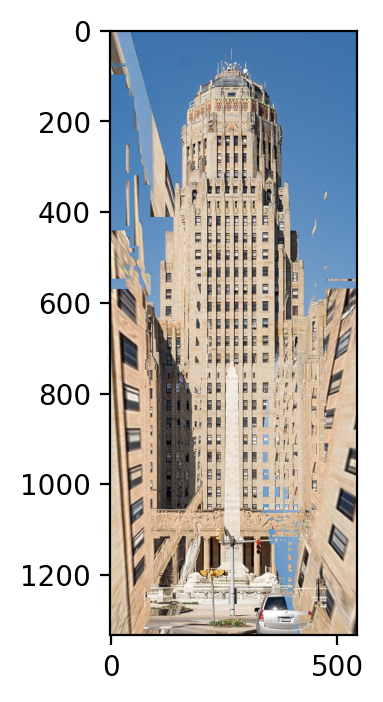

In [51]:
plt.figure(dpi=200)
plt.imshow(q)

In [606]:
max(graph, key=len(graph.get))

TypeError: object of type 'builtin_function_or_method' has no len()

In [603]:
graph

{0: [3], 1: [2], 2: [], 3: [0, 1], 4: []}

In [605]:
max(graph)

4

In [607]:
max(graph, key= lambda x: len(set(graph[x])))

3

In [615]:
(cross > cross.mean()).astype(int)

array([[0, 1, 0, 1],
       [1, 0, 1, 1],
       [0, 1, 0, 0],
       [1, 1, 0, 0]])

In [614]:
cross.mean()

108.5625

In [616]:
cross

array([[  0., 163.,   2., 281.],
       [154.,   0., 193., 256.],
       [  5., 182.,   0.,   5.],
       [273., 220.,   3.,   0.]])

In [624]:
imsave('./project2/images/t3_1.png',np.rot90(img1))
imsave('./project2/images/t3_2.png',np.rot90(img2))
imsave('./project2/images/t3_3.png',np.rot90(img3))
imsave('./project2/images/t3_4.png',np.rot90(img4))

In [640]:
test = plt.imread("./project2/images/t2_1.png")

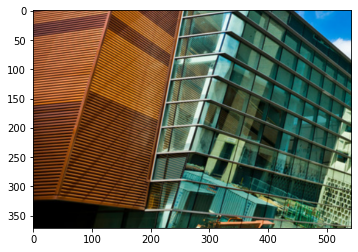

In [641]:
plt.imshow(test)

In [642]:
img1 = cv2.imread("./project2/images/t2_1.png")

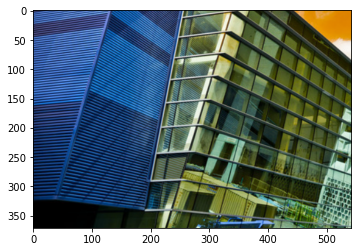

In [643]:
plt.imshow(img1)

In [644]:
test2 = plt.imread("./project2/images/t2_1.png")

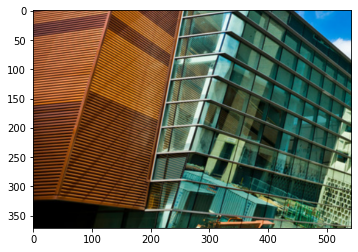

In [645]:
plt.imshow(test2)